In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, Concatenate, Lambda
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras import metrics
from collections import defaultdict
from keras.models import model_from_json
import matplotlib.pyplot as plt
import torch
import cv2
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from script.mixup_generator import MixupGenerator
from script.random_eraser import get_random_eraser
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
classes = 101 #(0, 100])
print("number of output classes: ",classes)

number of output classes:  101


In [3]:
f=torch.load('./data/features.pt').numpy()
target=torch.load('./data/age.pt').numpy()
gender=torch.load('./data/gender.pt').numpy()

In [4]:
features=np.concatenate([cv2.resize(img, (64,64))[None,:,:,:] for img in f], axis=0)

In [5]:
features.shape
del f

In [6]:
features.shape

(10, 64, 64, 3)

In [7]:
gender_classes = keras.utils.to_categorical(gender, 2)

In [8]:
target_classes = keras.utils.to_categorical(target, classes)
outout=np.concatenate([gender_classes, target_classes], axis=1)
print(outout.shape)

(10, 103)


In [9]:
train_x, test_x, train_y, test_y = train_test_split(features, outout, test_size=0.10)

In [10]:
#delete extra data
del features
del target
del gender
del target_classes
del gender_classes
del outout

In [11]:
train_g, train_a=train_y[:,:2],train_y[:,2:]
test_g, test_a=test_y[:,:2],test_y[:,2:]

In [19]:
from models.wide_resnet import WideResNet
def gen_model(img_size,pretrained= False):

    model=WideResNet(img_size, depth=16, k=8)()
    
    if pretrained==True:
        
        model.load_weights('./trained_models/weights.18-4.06.hdf5')
        #model.load_weights('./trained_models/wideresnet_age__.h5')
        
    return model
  

In [20]:
wn=True
aug=False
baseline=False


# epochs = 30
epochs = 2
batch_size = 32
lr=1e-2
size_train=train_x.shape[0]

model=gen_model(64)

if aug :
    
    datagen = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            preprocessing_function=get_random_eraser(v_l=0, v_h=255))

    training_generator = MixupGenerator(train_x, [train_g, train_a], batch_size=batch_size, alpha=0.2,
                                            datagen=datagen)()

    

In [21]:
class Schedule:

    def __init__(self, nb_epochs, initial_lr=0.1):
        self.epochs = nb_epochs
        self.initial_lr = initial_lr

    def __call__(self, epoch_idx):
        if epoch_idx < self.epochs * 0.25:
            return self.initial_lr
        elif epoch_idx < self.epochs * 0.50:
            return self.initial_lr * 0.2
        elif epoch_idx < self.epochs * 0.75:
            return self.initial_lr * 0.04

        return self.initial_lr * 0.008

callbacks = [LearningRateScheduler(schedule=Schedule(epochs, lr))]
sgd = keras.optimizers.SGD(lr=lr,  momentum=0.9, nesterov=True)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy']
                  , optimizer=sgd
                  , metrics=['accuracy']
                 )

Train on 9 samples, validate on 1 samples
Epoch 1/2
9/9 [==============================] - 4s 420ms/step - loss: 10.3809 - pred_gender_loss: 0.9142 - pred_age_loss: 4.8615 - pred_gender_accuracy: 0.2222 - pred_age_accuracy: 0.0000e+00 - val_loss: 36432.4414 - val_pred_gender_loss: 32946.2539 - val_pred_age_loss: 3481.5798 - val_pred_gender_accuracy: 0.0000e+00 - val_pred_age_accuracy: 0.0000e+00
Epoch 2/2
9/9 [==============================] - 0s 8ms/step - loss: 96.7547 - pred_gender_loss: 71.6585 - pred_age_loss: 20.4890 - pred_gender_accuracy: 0.7778 - pred_age_accuracy: 0.2222 - val_loss: 43517.7383 - val_pred_gender_loss: 39208.6914 - val_pred_age_loss: 4304.4365 - val_pred_gender_accuracy: 0.0000e+00 - val_pred_age_accuracy: 0.0000e+00


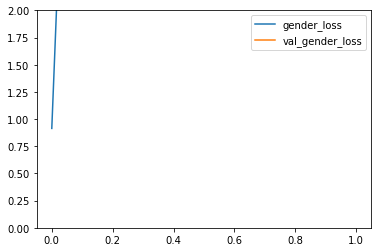

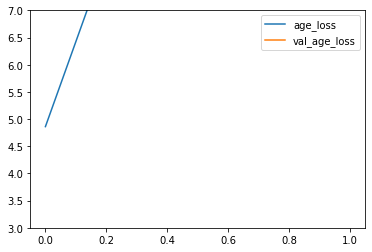

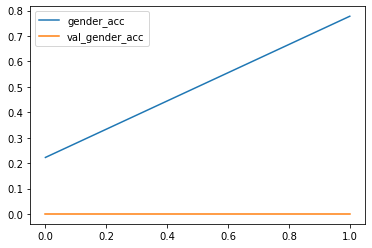

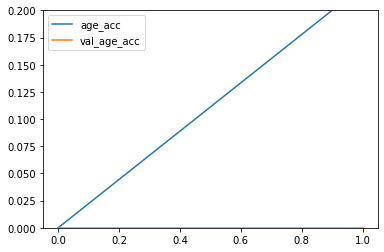

In [22]:
enableFit = True
#age_model=gen_model(101)
if enableFit:
    
    if aug:
        score = model.fit_generator(generator=training_generator,
                                   steps_per_epoch=size_train // batch_size,
                                   validation_data=(test_x, [test_g,test_a]),
                                   epochs=epochs, verbose=1)

        pd.DataFrame.from_dict(score.history).to_csv('./outputs/wideresnet_age_aug.csv')
        
        plt.plot(score.history['pred_gender_loss'], label='gender_loss')
        plt.plot(score.history['val_pred_gender_loss'], label='val_gender_loss')
        plt.legend(loc='best')   
        plt.ylim([0,2])
        plt.savefig('./outputs/wideresnet_aug_gender_loss.png')
        plt.show()


        plt.figure()
        plt.plot(score.history['pred_age_loss'], label='age_loss')
        plt.plot(score.history['val_pred_age_loss'], label='val_age_loss')

        plt.legend(loc='best') 
        plt.ylim([3,7])
        plt.savefig('./outputs/wideresnet_aug_age_loss.png')

        plt.show()
        plt.plot(score.history['pred_gender_accuracy'], label='gender_acc')
        plt.plot(score.history['val_pred_gender_accuracy'], label='val_gender_acc')
        plt.legend(loc='best')   
        plt.savefig('./outputs/wideresnet_aug_gender_acc.png')
        plt.show()
        plt.figure()

        plt.plot(score.history['pred_age_accuracy'], label='age_acc')
        plt.plot(score.history['val_pred_age_accuracy'], label='val_age_acc')
        plt.legend(loc='best')   
        plt.savefig('./outputs/wideresnet_aug_age_acc.png')
        plt.ylim([0,0.2])
        plt.show()

    else:
        score = model.fit(train_x, [train_g, train_a], epochs=epochs, batch_size=batch_size, validation_data=(test_x, [test_g,test_a])
                             , callbacks=callbacks)
            
        modelname='_'
        pd.DataFrame.from_dict(score.history).to_csv('./outputs/wideresnet_age_'+modelname+'.csv')
        plt.plot(score.history['pred_gender_loss'], label='gender_loss')
        plt.plot(score.history['val_pred_gender_loss'], label='val_gender_loss')
        plt.legend(loc='best')   
        plt.ylim([0,2])
        plt.savefig('./outputs/wideresnet_aug_gender_loss.png')
        plt.show()


        plt.figure()
        plt.plot(score.history['pred_age_loss'], label='age_loss')
        plt.plot(score.history['val_pred_age_loss'], label='val_age_loss')

        plt.legend(loc='best') 
        plt.ylim([3,7])
        plt.savefig('./outputs/wideresnet_aug_age_loss.png')

        plt.show()
        plt.plot(score.history['pred_gender_accuracy'], label='gender_acc')
        plt.plot(score.history['val_pred_gender_accuracy'], label='val_gender_acc')
        plt.legend(loc='best')   
        plt.savefig('./outputs/wideresnet_aug_gender_acc.png')
        plt.show()
        plt.figure()

        plt.plot(score.history['pred_age_accuracy'], label='age_acc')
        plt.plot(score.history['val_pred_age_accuracy'], label='val_age_acc')
        plt.legend(loc='best')   
        plt.savefig('./outputs/wideresnet_aug_age_acc.png')
        plt.ylim([0,0.2])
        plt.show()

else:
    age_model.load_weights("./trained_models/age_model_weights.h5")

# Model evaluation on test set

In [23]:
predictions = model.predict(test_x)
gender_predictions=predictions[0]
age_predictions=predictions[1]

In [24]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(age_predictions * output_indexes, axis = 1)

In [25]:
mae = 0

actual_mean = 0
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_a[i])
    
    abs_error = abs(prediction - actual)
    actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  13.0
instances:  1


In [26]:
pred_list = []; actual_list = []

for i in gender_predictions:
    pred_list.append(np.argmax(i))

for i in test_g: 
    actual_list.append(np.argmax(i))

cmt=confusion_matrix(actual_list, pred_list)
classification_report(actual_list, pred_list)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       1.0\n           1       0.00      0.00      0.00       0.0\n\n    accuracy                           0.00       1.0\n   macro avg       0.00      0.00      0.00       1.0\nweighted avg       0.00      0.00      0.00       1.0\n'